### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


#### __problema continuo__

Sea el problema bidimencional pulso gausiano rotatorio definido por la ecuacion: 
$$
\frac{\partial T}{\partial t} - \alpha \nabla  T =Q \  \text{en} \  M=\Omega \times (0,t_f) 
$$

Donde $u(x,t) \in \mathbb{R}$ 
$$\Omega $$
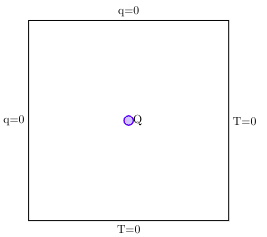

con: 

$$Q=10$$
$$\alpha =0.001$$
## Problema variacional

Encontrar un  $T \ \in \ V$  tal que 
$$
        \int \frac{\partial T}{\partial t}d\Omega +\int \alpha \nabla v \nabla T d\Omega  - \int_{\partial \Omega} \alpha q \cdot n ds - \int Qvd\Omega = 0
$$

In [32]:
import meshio
from fenics import *

def create_mesh(mesh, cell_type, prune_z=True):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read": [cell_data.astype(np.int32)]})
    return out_mesh
def compute_mesh():
  #os.system(f'gmsh -3 {drive_dir}Blade_CFD/{fileName}/Mesh/mesh.geo   -format msh2') #por preferencia se comenta esta linea para no  ejecutar el .geo y subir desde local el .msh

  msh = meshio.read('Mesh/mesh.msh' )
  triangle_mesh = create_mesh(msh,"triangle", True)
  line_mesh = create_mesh(msh, "line", True)
  meshio.write(f'Mesh/mesh.xdmf',triangle_mesh)
  meshio.write(f'Mesh/mesh_facets.xdmf',line_mesh)


def read_mesh():
  mesh = Mesh()
  mvc = MeshValueCollection("size_t", mesh, 2)
  with XDMFFile(f'Mesh/mesh.xdmf') as infile:
      infile.read(mesh)
      infile.read(mvc)
  subd = cpp.mesh.MeshFunctionSizet(mesh, mvc)

  mvc = MeshValueCollection("size_t", mesh, 1)
  with XDMFFile(f'Mesh/mesh_facets.xdmf') as infile:
      infile.read(mvc)
  contorno = cpp.mesh.MeshFunctionSizet(mesh, mvc)
  return(mesh,subd,contorno)

compute_mesh()
mesh,subd,chanfunc  =read_mesh()
print('Number of nodes:', mesh.num_vertices() )
print('Number of elements:', mesh.num_cells() )
print('Number of DOFs:',mesh.num_vertices()*3 )


Number of nodes: 11436
Number of elements: 22480
Number of DOFs: 34308


In [31]:
# Print log messages only from the root process in parallel
import matplotlib.pyplot as plt
parameters["std_out_all_processes"] = False;

# Define function spaces (P2-P1)
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

# Set parameter values
dt = 0.01
T = 10
nu = 0.01


# Define boundary conditions

bcu = []
bcu.append(DirichletBC(V,Constant((1,0)),chanfunc, 2))
bcu.append(DirichletBC(V,Constant((0,0)),chanfunc, 1))
bcp = []
bcp.append(DirichletBC(Q,Constant(0.0),chanfunc, 3))
# Create functions
u0 = Function(V)
u1 = Function(V)
p1 = Function(Q)

# Define coefficients
k = Constant(dt)
f = Constant((0, 0))

# Tentative velocity step
F1 = (1/k)*inner(u - u0, v)*dx + inner(grad(u0)*u0, v)*dx + \
     nu*inner(grad(u), grad(v))*dx - inner(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Pressure update
a2 = inner(grad(p), grad(q))*dx
L2 = -(1/k)*div(u1)*q*dx

# Velocity update
a3 = inner(u, v)*dx
L3 = inner(u1, v)*dx - k*inner(grad(p1), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Create files for storing solution
ufile = File("results/velocity.pvd")
pfile = File("results/pressure.pvd")

# Time-stepping
t = dt
while t < T + DOLFIN_EPS:


    # Compute tentative velocity step
    begin("Computing tentative velocity")
    b1 = assemble(L1)
    [bc.apply(A1, b1) for bc in bcu]
    solve(A1, u1.vector(), b1, "gmres", "default")
    end()

    # Pressure correction
    begin("Computing pressure correction")
    b2 = assemble(L2)
    [bc.apply(A2, b2) for bc in bcp]
    solve(A2, p1.vector(), b2, "cg", prec)
    end()

    # Velocity correction
    begin("Computing velocity correction")
    b3 = assemble(L3)
    [bc.apply(A3, b3) for bc in bcu]
    solve(A3, u1.vector(), b3, "gmres", "default")
    end()

    # Plot solution
    plot(p1, title="Pressure")
    plot(u1, title="Velocity")
    plt.show()
    # Save to file
    ufile << u1
    pfile << p1

    # Move to next time step
    u0.assign(u1)
    t += dt


AttributeError: module 'dolfin.mesh' has no attribute 'ufl_cell'

## definicion funciones 

In [29]:
from __future__ import print_function
from fenics import *  
import ufl # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
from matplotlib.legend_handler import HandlerLine2D
from label_lines import * #graficas 
import math
import scipy
import time
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import pandas as pd
import sys
import os
from scipy import integrate
from pathlib import Path
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
parameters['linear_algebra_backend'] = 'Eigen'
parameters["ghost_mode"] = "shared_facet"

start_code = time.time()
def fi (A,m,tau=1):
    d=scipy.sparse.identity(m)
    exp_A =scipy.linalg.expm(tau*A)
    return (exp_A-d)*spsl.spsolve(tau*A,d) , exp_A
# algoritmos de arnoldi
def arnoldi_iteration_m(A, b,tau,n):
    m = A.shape[0]
    h = np.zeros((n + 1, n))
    Q = np.zeros((m, n + 1))
    e_1=np.zeros(n)
    e_1[0]=1
    e_m=np.zeros(n)
    e_m[n-1]=1
    beta= np.linalg.norm(b)
    q = b / beta
    Q[:, 0] = q
    for k in range(n):
        v = A.dot(q)
        for j in range(k + 1):
            h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        q = v / h[k + 1, k]
        Q[:, k + 1] = q

    fi_m,exp_H =fi(h[0:n, 0:n],n,tau)
    error = beta*abs(h[n,n-1]*tau*e_m.dot(np.array(fi_m.dot(e_1))[0]))
    print(f"H dim= {Q[:,0:n].shape[1]} error = {error}")
          
    return Q[:,0:n], h[0:n, 0:n],fi_m,e_1,n,exp_H

def arnoldi_iteration(A, b,tau):
    m = A.shape[0]
    beta= np.linalg.norm(b)
    tol=1E-3
    n_int=4
    n=n_int
    error=1
    #print("beta on er",beta)
    eta=1/sqrt(2)
    H = np.zeros((n + 1, n))
    V = np.zeros((m, n + 1))
    V[:, 0] = b / beta
    j=0
    while error >= tol:
        if n>2 :
            H=np.pad(H, [(0, 1), (0, 1)], mode='constant', constant_values=0)
            V=np.pad(V, [(0, 0), (0, 1)], mode='constant', constant_values=0)
        e_m=np.zeros(n)
        e_m[n-1]=1
        e_1=np.zeros(n)
        e_1[0]=1
        v = A.dot(V[:, j])
        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i].conj(), v)  # <-- V needs conjugation!
            v = v - H[i, j] * V[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        V[:, j + 1] = v / H[j + 1, j]
        j += 1
        if n>n_int or (n==n_int and j==n_int):
            fi_m,exp_H =fi(H[0:n, 0:n],n,tau)
            error = beta*abs(H[n,n-1]*tau*e_m.dot(np.array(fi_m.dot(e_1))[0]))
            n += 1
        if stage_m:
            print(f"H dim= {V.shape[1]} error = {error}")
    print(f"H dim= {V.shape[1]} error = {error}")
    return V[:,0:n-1], H[0:n-1, 0:n-1],fi_m,e_1,n,exp_H 
class left(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0],0) and on_boundary
class right(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0],1)
def on_boundary(x, on_boundary):
    return on_boundary
def exp_form(mesh,flux_method,C_file):
    orden =1
    V=FunctionSpace(mesh,"DG",orden)
    V_w =VectorFunctionSpace(mesh, "DG", 1)
    w=project(u1, V_w) 
    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    n=FacetNormal(mesh)
    
    u_n = Function(V)  # Interpola u_D en el espacio de funciones V    
    u_n = project(u_0, V)  # Interpola u_D en el espacio de funciones V

    #bcs =[]
    #bcs.append(DirichletBC(V, Constant(0.0),contorno,2))
    #bcs.append(DirichletBC(V, Constant(0.0),contorno,1))
    bcs =DirichletBC(V, u_analytical_bcs, on_boundary,method='geometric') 
    alpha=1
    h= mesh.cells().size
    ds = Measure('ds', domain=mesh, subdomain_data=contorno)
    
    if 'LaxF' == flux_method:
        C = w[0]
        flux = dot(avg(w*u),n('+')) + 0.5*C*jump(u)
    elif 'upwind' == flux_method:
        un = (dot(w, n) + abs(dot(w,n)))/2.0
        flux = jump(un*u)
    
    dif_nflux = -k*dot(jump(u,n),avg(grad(v)))*dS - k*dot(avg(grad(u)),jump(v,n))*dS \
    + (alpha/h)*dot(jump(u,n),jump(v,n))*dS #flujo difusivo
    
    adv_nflux =  dot(jump(v), flux)*dS + dot(v, u_analytical)*ds

    F_fem =- dot(grad(v),w*u)*dx + adv_nflux - dot(k*grad(u), grad(v))*dx + dif_nflux

    K_fem , Q_fem = lhs(F_fem), rhs(F_fem) 
    
    C_fem=u*v*dx
    if stage_m:
        print('C invertion init')
    #ensamble matriz capacitiva 

    C_petsc = PETScMatrix()
    C=assemble(C_fem, tensor=C_petsc)
    if orden == 1:
        dof_elem=mesh.ufl_cell().num_edges()
    elif orden == 2:
        dof_elem=mesh.ufl_cell().num_edges()*2
    elif orden == 3:
        dof_elem=mesh.ufl_cell().num_edges()*3 + 1
    
    C.mat().setBlockSizes(dof_elem,dof_elem)
    C_1 = C.mat().invertBlockDiagonal()
    C_1 =scipy.sparse.block_diag([C_1[i] for i in range(C_1.shape[0])], format='csc')
    if stage_m:
        print('C invertion finish')
    #ensamble matriz de rigidez
    K_petsc = PETScMatrix()
    assemble(K_fem, tensor=K_petsc)
    bcs.apply(K_petsc)
    

    A=C_1 * (-1) * K_petsc.mat()
    # print("K matrix" , K_.toarray())
    # print("C matrix" , C_.toarray())  
    return(V,u,v,A,C_1,Q_fem,u_n,bcs)

def Q_t(Q_fem,C_1,u_t,v_t,f,bcs):

    Q_v=assemble(Q_fem)
    bcs.apply(Q_v)
    Q_ = -Q_v.get_local()
    Q_a =C_1.dot(Q_)
    return Q_a
def exp_solver(A,u_i,n,table,auto,m_u,u=0):
    arnoldi_ti=time.time()
    Beta=np.linalg.norm(u_i)
    if stage_m:
        print('Arnoldi iteration init')
    if auto:
        V_m,H_m,fi_m,e_1,m,exp_H  = arnoldi_iteration(A,u_i,real_dt)
    else:
        V_m,H_m,fi_m,e_1,m,exp_H  = arnoldi_iteration_m(A,u_i,real_dt,m_u)
    arnoldi_t=time.time()-arnoldi_ti
    if stage_m:
        print(f'KSP projection time = {arnoldi_t}')
    solver_ti=time.time()
    if n==0:
        u = real_dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)+u_n.vector().get_local()
    else:
        u += real_dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)
    solver_t=time.time() -solver_ti
    table.append([arnoldi_t,solver_t,V_m.shape[1],t])
    return(u)
    return(u_i)
def BDF_form(mesh,pconst,flux_method):
    V=FunctionSpace(mesh,"DG",1)
    V_w =VectorFunctionSpace(mesh, "DG", 1)
    w=project(u1, V_w)
    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    n=FacetNormal(mesh)
    
    u_n = Function(V)  # Interpola u_D en el espacio de funciones V
    u_nn = Function(V) 
    u_nnn = Function(V)
    
    u_n = project(u_0, V)  # Interpola u_D en el espacio de funciones V
    u_nn = project(u_0, V) 
    u_nnn = project(u_0, V) 
    

    du=pconst[0]*u
    du_n=pconst[1]*u_n
    du_nn=pconst[2]*u_nn
    du_nnn=pconst[3]*u_nnn
    du_t= du+du_n +du_nn +du_nnn

    #bcs =[]
    #bcs.append(DirichletBC(V, Constant(0.0),contorno,2))
    #bcs.append(DirichletBC(V, Constant(0.0),contorno,1))
    bcs =DirichletBC(V, u_analytical, on_boundary,method='geometric') 
    alpha=1
    h= mesh.cells().size
    ds = Measure('ds', domain=mesh, subdomain_data=contorno)
    
    if 'LaxF' == flux_method:
        C = w[0]
        flux = dot(avg(w*u),n('+')) + 0.5*C*jump(u)
    elif 'upwind' == flux_method:
        un = (dot(w, n) + abs(dot(w,n)))/2.0
        flux = jump(un*u)
    
    dif_nflux = -k*dot(jump(u,n),avg(grad(v)))*dS - k*dot(avg(grad(u)),jump(v,n))*dS \
    + (alpha/h)*dot(jump(u,n),jump(v,n))*dS #flujo difusivo
    
    adv_nflux =  dot(jump(v), flux)*dS + dot(v, u_analytical)*ds

    F = du_t*v*dx - real_dt*dot(grad(v),w*u)*dx + real_dt*adv_nflux - real_dt*dot(k*grad(u), grad(v))*dx + real_dt*dif_nflux
    
    #F = du_t*v*dx - Constant(real_dt)*dot(grad(v), w*u)*dx 
    #F += Constant(real_dt)*dot(jump(v), flux)*dS + Constant(real_dt)*dot(v, u_analytical*u)*ds
    
    
    L, R = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación
    L_se=assemble(R)
    return(V,L,R,u_n,u_nn,u_nnn,bcs)





### Problema Homogeneo

In [33]:
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
start_code = time.time()
dt = 0.1

ny  = 10 
nx = ny*10
solver  = "exp"  # time integration method
flux_method = "upwind"
mode_KSP = "auto"
stage_m =False

# Parámetros de simulación

T = 10         # Tiempo final
num_steps = int(round(T/dt,0))# Número de pasos de tiempo
real_dt= T/num_steps
k=Constant(0.01)


vtkfile_u_exp = XDMFFile(f"results/u_exp.xdmf")
vtkfile_u_exp.parameters["flush_output"] = True
vtkfile_u_exp.parameters["rewrite_function_mesh"] = False
vtkfile_u = XDMFFile(f"results/u_analytical.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False
vtkfile_ubdf = XDMFFile(f"results/u_{solver}.xdmf")
vtkfile_ubdf.parameters["flush_output"] = True
vtkfile_ubdf.parameters["rewrite_function_mesh"] = False


#f=Expression('x[0]*(6*t - pow(x[0], 2) - 4*pow(x[0], 2)*t*t)*exp(-t*pow(x[0], 2))',t=0,degree=2)
f=Expression('0',t=0,degree=2) 
#q=Expression('-1',t=0,degree=2) #neumman BC
u_analytical = Expression('1',t=0,degree=2)
u_analytical_bcs = Expression('-1',t=0,degree=2)
u_0 = Expression('(x[0] <= 0.5 && x[1] <= 0.5) || (x[0] >= 0.5 && x[1] >= 0.5) ? 1.0 : 0',degree=2)
BDF_coef = {"BDF1":[1,-1,0,0],"BDF2":[3./2,-2,1./2,0.0],"BDF3":[11/6,-3,3/2,-1/3],"BDF_OP":[0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3]}

# Creación de la malla y definición del espacio de funciones


start = 0
x_end = 10
#mesh = RectangleMesh(Point(start, 0),Point(x_end,1),nx,ny,"crossed")
contorno = chanfunc #MeshFunction("size_t", mesh, mesh.topology().dim()-1)
#left().mark(contorno, 1)
#right().mark(contorno, 2)
print('Number of nodes:', mesh.num_vertices() )
print('Number of elements:', mesh.num_cells() )
print('Number of DOFs:',mesh.num_vertices() )

try:
    os.mkdir(f"results_dt_{real_dt}") 
except FileExistsError:
    pass
t= 0
if solver == "exp":
    C_file= False#sys.argv[5] == "y"
    assemble_ti=time.time()
    V,u_t,v_t,A,C_1,Q_a,u_n,bcs = exp_form(mesh,flux_method,C_file)
    
    if stage_m:
        print(f"Tiempo de ensamblaje {time.time()- assemble_ti}")
elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
    V,L,R,u_n,u_nn,u_nnn,bcs = BDF_form(mesh,BDF_coef[solver],flux_method)
else: 
    print("esquema de integración temporal erroneo")
    exit()


u_=Function(V)
L2=[]
table =[]
sol=[]
for n in range(num_steps):
    #f.t=t
    #q.t=t
    t += real_dt
    #u_a.t=t
    u_analytical.t=t
    u_analytical_bcs.t=t 
    print(f'step:{n+1} of {num_steps} time = {t}')
    if solver == "exp":
        if mode_KSP == 'auto': 
            Q=Q_t(Q_a,C_1,u_t,v_t,f,bcs)

            if n ==0:
                u_i=np.dot(A,u_n.vector().get_local())+Q
                u =exp_solver(A,u_i,n,table,True,0)
            else:
                u_i=np.dot(A,np.array(u)[0])+Q
                u =exp_solver(A,u_i,n,table,True,0,u)
        else: 
            m_u = int(mode_KSP)
            Q=Q_t(Q_a,C_1,u_t,v_t,f,bcs)
            if n ==0:
                u_i=np.dot(A,u_n.vector().get_local())+Q
                u =exp_solver(A,u_i,n,table,False,m_u)
            else:
                u_i=np.dot(A,np.array(u)[0])+Q
                u =exp_solver(A,u_i,n,table,False,m_u,u)
        u_.vector()[:]=np.array(u)[0]
    elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):

        solve(L == R, u_,bcs)
        
        u_nnn.assign(u_nn)
        u_nn.assign(u_n)
        u_n.assign(u_)
    u_.rename("u_", "u_");vtkfile_u_exp.write(u_, t)  
    x_cor=np.linspace(start,x_end,100)

    u_ana = interpolate(u_analytical,V)
    L2_norm=assemble((u_ - u_analytical)**2 * dx)**0.5
    L2.append([L2_norm,t])
    print(f'step:{n+1} of {num_steps} time = {t}, L2 error = {L2_norm}')


Number of nodes: 11436
Number of elements: 22480
Number of DOFs: 11436


TypeError: Cannot convert csc_matrix to petsc4py.PETSc.Mat

In [3]:
dir(mesh)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_repr_html_',
 '_repr_svg_',
 'bounding_box_tree',
 'cell_name',
 'cell_orientations',
 'cells',
 'color',
 'coordinates',
 'data',
 'domains',
 'geometric_dimension',
 'geometry',
 'hash',
 'hmax',
 'hmin',
 'id',
 'init',
 'init_cell_orientations',
 'init_global',
 'label',
 'mpi_comm',
 'name',
 'num_cells',
 'num_edges',
 'num_entities',
 'num_entities_global',
 'num_faces',
 'num_facets',
 'num_vertices',
 'order',
 'ordered',
 'parameters',
 'rename',
 'rmax',
 'rmin',
 'rotate',
 'scale',
 'smooth',
 'smooth_boundary',
 'snap_boundary',
 'topology',
 'translate',
 'type',
 'ufl_cell',
 'ufl_coordinate_element',
 

Number of nodes: 2111
Number of elements: 4000
Number of DOFs: 2111
step:1 of 100 time = 0.1


/home/sebastian/anaconda3/envs/fenics_base/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/home/sebastian/anaconda3/envs/fenics_base/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


H dim= 40 error = 2.7221612500848606e-05
step:1 of 100 time = 0.1, L2 error = 0.00632907247320973
step:2 of 100 time = 0.2
H dim= 40 error = 1.1904730101299294e-05
step:2 of 100 time = 0.2, L2 error = 0.0067441559090563735
step:3 of 100 time = 0.30000000000000004
H dim= 40 error = 2.6960083490706745e-05
step:3 of 100 time = 0.30000000000000004, L2 error = 0.006756630596528608
step:4 of 100 time = 0.4
H dim= 40 error = 2.371617368401668e-05
step:4 of 100 time = 0.4, L2 error = 0.006764130764190682
step:5 of 100 time = 0.5
H dim= 40 error = 2.4824277321547533e-05
step:5 of 100 time = 0.5, L2 error = 0.006774108724854173
step:6 of 100 time = 0.6
H dim= 40 error = 3.085231566896321e-05
step:6 of 100 time = 0.6, L2 error = 0.006786498680463732
step:7 of 100 time = 0.7
H dim= 40 error = 3.7991963937897055e-05
step:7 of 100 time = 0.7, L2 error = 0.0068013824726808345
step:8 of 100 time = 0.7999999999999999
H dim= 40 error = 3.66200772526951e-05
step:8 of 100 time = 0.7999999999999999, L2 err

H dim= 40 error = 1.7614259979648847e-05
step:57 of 100 time = 5.699999999999996, L2 error = 0.01264974892865411
step:58 of 100 time = 5.799999999999995
H dim= 40 error = 1.739033633705422e-05
step:58 of 100 time = 5.799999999999995, L2 error = 0.01276041636272751
step:59 of 100 time = 5.899999999999995
H dim= 40 error = 1.7039902639388195e-05
step:59 of 100 time = 5.899999999999995, L2 error = 0.012814545974307659
step:60 of 100 time = 5.999999999999995
H dim= 40 error = 1.6540102969804427e-05
step:60 of 100 time = 5.999999999999995, L2 error = 0.012802807829181502
step:61 of 100 time = 6.099999999999994
H dim= 40 error = 1.5918961205625736e-05
step:61 of 100 time = 6.099999999999994, L2 error = 0.01272145029242181
step:62 of 100 time = 6.199999999999994
H dim= 40 error = 1.5167362309631207e-05
step:62 of 100 time = 6.199999999999994, L2 error = 0.012575472843327098
step:63 of 100 time = 6.299999999999994
H dim= 40 error = 1.4301358208324162e-05
step:63 of 100 time = 6.299999999999994

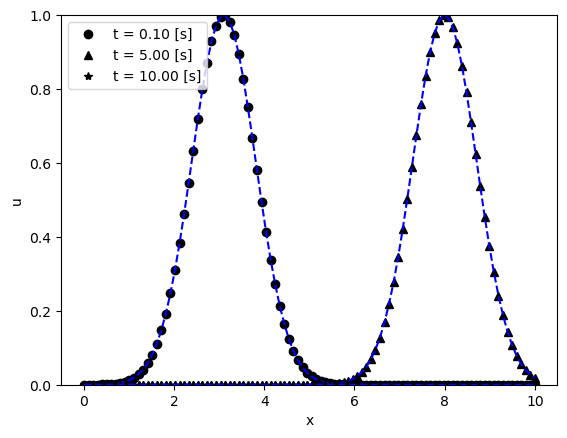

In [2]:
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
start_code = time.time()
dt = 0.1

ny  = 10 
nx = ny*10
solver  = "exp"  # time integration method
flux_method = "upwind"
mode_KSP = "40"
stage_m =False

# Parámetros de simulación

T = 10         # Tiempo final
num_steps = int(round(T/dt,0))# Número de pasos de tiempo
real_dt= T/num_steps
k=Constant(0.0001)
w=Constant((1,0))

vtkfile_u_exp = XDMFFile(f"results/u_exp.xdmf")
vtkfile_u_exp.parameters["flush_output"] = True
vtkfile_u_exp.parameters["rewrite_function_mesh"] = False
vtkfile_u = XDMFFile(f"results/u_analytical.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False
vtkfile_ubdf = XDMFFile(f"results/u_{solver}.xdmf")
vtkfile_ubdf.parameters["flush_output"] = True
vtkfile_ubdf.parameters["rewrite_function_mesh"] = False


#f=Expression('x[0]*(6*t - pow(x[0], 2) - 4*pow(x[0], 2)*t*t)*exp(-t*pow(x[0], 2))',t=0,degree=2)
f=Expression('0',t=0,degree=2) 
#q=Expression('-1',t=0,degree=2) #neumman BC
u_analytical = Expression('1/(sqrt(1+0.0004*t))*exp(-pow((x[0]-3-t),2)/(1+0.0004*t))',t=0,degree=2)
u_analytical_bcs = Expression('-1/(sqrt(1+0.0004*t))*exp(-pow((x[0]-3-t),2)/(1+0.0004*t))',t=0,degree=2)
u_0 = Expression('exp(-pow((x[0]-3),2))',degree=2)
BDF_coef = {"BDF1":[1,-1,0,0],"BDF2":[3./2,-2,1./2,0.0],"BDF3":[11/6,-3,3/2,-1/3],"BDF_OP":[0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3]}

# Creación de la malla y definición del espacio de funciones


start = 0
x_end = 10
mesh = RectangleMesh(Point(start, 0),Point(x_end,1),nx,ny,"crossed")
contorno = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
left().mark(contorno, 1)
right().mark(contorno, 2)
print('Number of nodes:', mesh.num_vertices() )
print('Number of elements:', mesh.num_cells() )
print('Number of DOFs:',mesh.num_vertices() )

try:
    os.mkdir(f"results_dt_{real_dt}") 
except FileExistsError:
    pass
t= 0
if solver == "exp":
    C_file= False#sys.argv[5] == "y"
    assemble_ti=time.time()
    V,u_t,v_t,A,C_1,Q_a,u_n,bcs = exp_form(mesh,flux_method,C_file)
    
    if stage_m:
        print(f"Tiempo de ensamblaje {time.time()- assemble_ti}")
elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
    V,L,R,u_n,u_nn,u_nnn,bcs = BDF_form(mesh,BDF_coef[solver],flux_method)
else: 
    print("esquema de integración temporal erroneo")
    exit()


u_=Function(V)
L2=[]
table =[]
sol=[]
for n in range(num_steps):
    #f.t=t
    #q.t=t
    t += real_dt
    #u_a.t=t
    u_analytical.t=t
    u_analytical_bcs.t=t 
    print(f'step:{n+1} of {num_steps} time = {t}')
    if solver == "exp":
        if mode_KSP == 'auto': 
            Q=Q_t(Q_a,C_1,u_t,v_t,f,bcs)

            if n ==0:
                u_i=np.dot(A,u_n.vector().get_local())+Q
                u =exp_solver(A,u_i,n,table,True,0)
            else:
                u_i=np.dot(A,np.array(u)[0])+Q
                u =exp_solver(A,u_i,n,table,True,0,u)
        else: 
            m_u = int(mode_KSP)
            Q=Q_t(Q_a,C_1,u_t,v_t,f,bcs)
            if n ==0:
                u_i=np.dot(A,u_n.vector().get_local())+Q
                u =exp_solver(A,u_i,n,table,False,m_u)
            else:
                u_i=np.dot(A,np.array(u)[0])+Q
                u =exp_solver(A,u_i,n,table,False,m_u,u)
        u_.vector()[:]=np.array(u)[0]
    elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):

        solve(L == R, u_,bcs)
        
        u_nnn.assign(u_nn)
        u_nn.assign(u_n)
        u_n.assign(u_)
    u_.rename("u_", "u_");vtkfile_u_exp.write(u_, t)  
    x_cor=np.linspace(start,x_end,100)
    u_p=[]
    u_an=[]
    for i in x_cor:
        u_p.append(u_(i,0.5))
        u_an.append(u_analytical(i,0.5))
    if near(t,real_dt,real_dt/2) or near(t,5,real_dt/2) or near(t,10,real_dt/2):
        if near(t,real_dt,real_dt/2):
            plt.plot(x_cor,u_p,'ko',label=f't = {t:.2f} [s]')
        elif near(t,5,real_dt/2):
            plt.plot(x_cor,u_p,'k^',label=f't = {t:.2f} [s]')
        elif near(t,10,real_dt/2):
            plt.plot(x_cor,u_p,'k*',label=f't = {t:.2f} [s]')
        plt.plot(x_cor,u_an,'b--')
       
    u_ana = interpolate(u_analytical,V)
    L2_norm=assemble((u_ - u_analytical)**2 * dx)**0.5
    L2.append([L2_norm,t])
    print(f'step:{n+1} of {num_steps} time = {t}, L2 error = {L2_norm}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.ylim(0,1)
    plt.legend(loc='upper left')
plt.show()

In [14]:

start_code = time.time()
assemble_c =assemble(C_fem).array()
N_degree=assemble_c.shape[0]
C_=scipy.sparse.csc_matrix(assemble_c)
I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))
C_1=scipy.sparse.linalg.spsolve(C_,I_n)
print(f"invertion time scipy= {time.time()-start_code}" )
#C_1.toarray()

invertion time scipy= 0.004875659942626953


In [5]:
mesh = RectangleMesh(Point(0, 0),Point(1,1),1,1,"left")
V=FunctionSpace(mesh,"DG",1)
# Obtener los índices de los grados de libertad para cada celda
dofmap = V.dofmap()

# Crear una matriz global dispersa para almacenar las matrices inversas locales
#A_global.setSizes(len(V.dofmap().dofs()), len(V.dofmap().dofs()))
# Iterar sobre los elementos y calcular la matriz inversa local
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V) 

C_fem = u*v*dx
i=0
print('start')
start_code =time.time()
for cell in cells(mesh):
    inv_t=time.time()
    # Extraer la matriz local para el elemento actual
    A_local = assemble_local(C_fem, cell)

    # Calcular la inversa de la matriz local
    A_local_inv = np.linalg.inv(A_local)
    # Ensamblar la matriz inversa local en la matriz global
    if cell.index() ==0 : 
        C_l_1 = A_local_inv.copy()
    else :
        C_l_1=scipy.linalg.block_diag(C_l_1,A_local_inv)
    print(f'elemento {cell.index()} tiempo de inversión : {time.time()-inv_t}')
# Finalizar el ensamblaje de la matriz global

print(f"invertion time local= {time.time()-start_code}" )


    


start
elemento 0 tiempo de inversión : 0.0006718635559082031
elemento 1 tiempo de inversión : 0.0005269050598144531
invertion time local= 0.0015337467193603516


In [8]:
inv_t=time.time()
C_petsc = PETScMatrix()

C=assemble(C_fem, tensor=C_petsc)
dof_elem=mesh.ufl_cell().num_edges()
C.mat().setBlockSizes(dof_elem,dof_elem)
C_1 = C.mat().invertBlockDiagonal()


C_1 =scipy.linalg.block_diag(*C_1)
print(f"invertion time local= {time.time()-inv_t}" )

invertion time local= 0.0009028911590576172


In [28]:
from dolfin import *
from petsc4py import PETSc
# Crear una matriz genérica
AA = BlockMatrix(2, 2)


A = PETSc.Mat().createAIJ(A_local_inv.shape)
type(A)
# Asignar un tamaño a la matriz (por ejemplo, 3x3)


# Llenar la matriz con algunos valores
A[:, :] = A_local_inv

A.assemble()
# Limpiar la matriz (establecer todos los elementos a cero)


# Imprimir la matriz para verificar
print(A)

['AssemblyType',
 'DuplicateOption',
 'FactorShiftType',
 'H2OpusCompress',
 'H2OpusLowRankUpdate',
 'H2OpusOrthogonalize',
 'InfoType',
 'Option',
 'OrderingType',
 'PtAP',
 'SOR',
 'SORType',
 'SolverType',
 'Stencil',
 'Structure',
 'Type',
 '__add__',
 '__bool__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__itruediv__',
 '__le__',
 '__lt__',
 '__matmul__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pos__',
 '__pyx_vtable__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmatmul__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 'appendOptionsPrefix

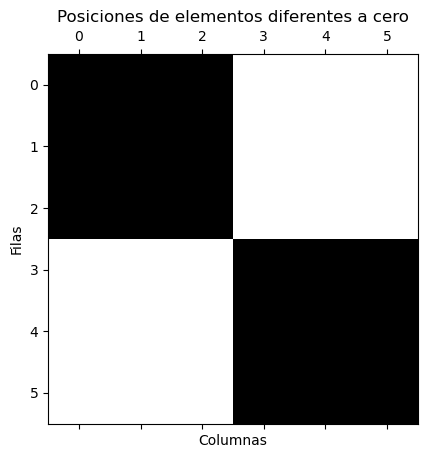

In [32]:
plt.spy(a.array())
plt.title('Posiciones de elementos diferentes a cero')
plt.xlabel('Columnas')
plt.ylabel('Filas')
plt.show()

In [10]:
matriz_penalizada

array([[ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
       [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
       [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
       [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
       [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
       [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00]])

In [13]:
np.savetxt('out.txt',matriz_penalizada)

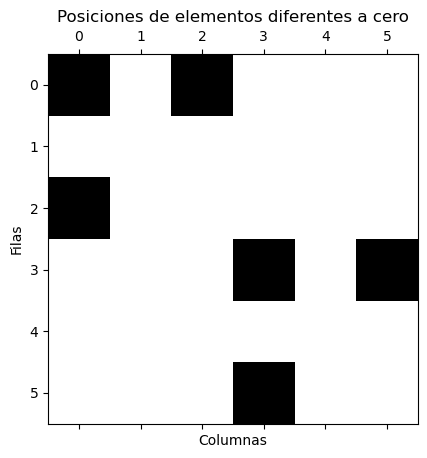

In [9]:
matriz=C_1 - C_l_1
matriz_penalizada = np.where(matriz < 1e-15, 0.0, matriz)

plt.spy(matriz_penalizada)
plt.title('Posiciones de elementos diferentes a cero')
plt.xlabel('Columnas')
plt.ylabel('Filas')
plt.show()

In [51]:
matriz_penalizada

array([[ 0.00,  0.00,  0.00, ...,  0.00,  0.00,  0.00],
       [ 0.00,  0.00,  0.00, ...,  0.00,  0.00,  0.00],
       [ 0.00,  0.00,  0.00, ...,  0.00,  0.00,  0.00],
       ...,
       [ 0.00,  0.00,  0.00, ...,  0.00,  0.00,  0.00],
       [ 0.00,  0.00,  0.00, ...,  0.00,  0.00,  0.00],
       [ 0.00,  0.00,  0.00, ...,  0.00,  0.00,  0.00]])

In [5]:
dofmap = V.dofmap()

# Crear una matriz global dispersa para almacenar las matrices inversas locales
A_global =la.GenericMatrix
A_global.init(V.dofmap().dofs(), V.dofmap().dofs())

# Iterar sobre los elementos y ensamblar las matrices inversas locales en la matriz global
for cell in cells(mesh):
    # Extraer la matriz local para el elemento actual
    A_local = assemble_local(C_fem, cell)
    
    # Calcular la inversa de la matriz local
    A_local_inv = np.linalg.inv(A_local)
    
    # Obtener los índices de los grados de libertad locales del elemento actual
    dofs = dofmap.cell_dofs(cell.index())
    
    # Ensamblar la matriz inversa local en la matriz global
    for i_local, i_global in enumerate(dofs):
        for j_local, j_global in enumerate(dofs):
            A_global.add(i_global, j_global, A_local_inv[i_local, j_local])

# Finalizar el ensamblaje de la matriz global
A_global.apply("add")

# Convertir la matriz PETSc a formato numpy para su visualización
A_global_np = A_global.mat().getDenseArray()

# Imprimir la matriz global ensamblada
print("Matriz global ensamblada con las inversas locales:")
print(A_global_np)

AttributeError: module 'dolfin.la' has no attribute 'GenericMatrix'

In [8]:
dir(la.cpp)

['MPI',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__version__',
 'adaptivity',
 'ale',
 'common',
 'fem',
 'function',
 'generation',
 'geometry',
 'graph',
 'io',
 'la',
 'log',
 'math',
 'mesh',
 'multistage',
 'nls',
 'parameter',
 'refinement',
 'ts',
 'warning']

In [10]:
from dolfin import *
import numpy as np

# Crear una matriz de ejemplo en NumPy
numpy_matrix = np.array([[4, 1, 2],
                         [1, 3, 0],
                         [2, 0, 1]])

# Obtener el tamaño de la matriz
n = numpy_matrix.shape[0]

# Crear un objeto PETScMatrix en FEniCS
A_fenics = Matrix()

# Inicializar la matriz con el tamaño adecuado
A_fenics.init([n, n], [n, n])

# Llenar la matriz de FEniCS con los valores de la matriz de NumPy
for i in range(n):
    for j in range(n):
        A_fenics.set(i, j, numpy_matrix[i, j])

# Aplicar la operación de ensamblaje
A_fenics.apply("insert")

# Imprimir la matriz de FEniCS
print("Matriz convertida a PETScMatrix en FEniCS:")
print(A_fenics)

TypeError: init(): incompatible function arguments. The following argument types are supported:
    1. (self: dolfin.cpp.la.GenericTensor, arg0: dolfin.cpp.la.TensorLayout) -> None

Invoked with: <dolfin.cpp.la.Matrix object at 0x7f9f65fc05f0>, [3, 3], [3, 3]

In [11]:
dir(A_fenics)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__itruediv__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 'apply',
 'array',
 'axpy',
 'copy',
 'empty',
 'factory',
 'get',
 'get_diagonal',
 'getrow',
 'id',
 'ident',
 'ident_zeros',
 'init',
 'init_vector',
 'instance',
 'label',
 'local_range',
 'mpi_comm',
 'mult',
 'name',
 'nnz',
 'norm',
 'parameters',
 'rank',
 'rename',
 'set',
 'set_diagonal',
 'size',
 'str',
 'transpmult',
 'zero']

In [ ]:
from petsc4py import PETSc
C_petsc = PETScMatrix()
assemble(C_fem, tensor=C_petsc)
start_code = time.time()

dyn_matrix_dim=C_petsc.mat().size[0]
m_cols_rows =C_petsc.mat().size[1]
I = PETSc.Mat().create()
I.setSizes((dyn_matrix_dim,m_cols_rows))
I.setType("dense")
I.setFromOptions()
I.setUp()
Rstart, Rend = I.getOwnershipRange()

# Fill the matrix B 
if (Rstart < m_cols_rows) and (Rend <= m_cols_rows):
    for i in range(Rstart, Rend):
        I[i,i] = 1
if (Rstart < m_cols_rows) and (Rend >= m_cols_rows):
    for i in range(Rstart, m_cols_rows):
        I[i,i] = 1
# Assemble B 
I.assemble()

# Set up matrix x
C_1 = PETSc.Mat().create()
C_1.setSizes((dyn_matrix_dim,m_cols_rows))
C_1.setType("dense")
C_1.setFromOptions()
C_1.setUp()
C_1.assemble()

C_petsc.mat().matSolve(I,C_1)

print(f"invertion time Petsc= {time.time()-start_code}" )


In [10]:
import numpy as np
from petsc4py import PETSc

def calcular_inversa_petsc(A_np):
    """
    Calcula la inversa de una matriz utilizando PETSc.

    Parámetros:
        A_np (numpy.ndarray): Matriz cuadrada que se desea invertir.

    Retorna:
        numpy.ndarray: Matriz inversa de A_np.
    """
    # Crear el objeto de matriz PETSc y configurarlo
    n = A_np.shape[0]
    A_petsc = PETSc.Mat().createAIJ([n, n])
    A_petsc.setUp()

    # Rellenar la matriz PETSc con los valores de la matriz numpy
    for i in range(n):
        for j in range(n):
            A_petsc[i, j] = A_np[i, j]

    A_petsc.assemble()

    # Crear el vector identidad y la matriz de salida para almacenar la inversa
    inversa_np = np.zeros_like(A_np)

    # Resolver el sistema A * X = I para cada columna de la matriz identidad
    for k in range(n):
        # Crear los vectores PETSc para el lado derecho y la solución
        b = PETSc.Vec().createSeq(n)
        x = PETSc.Vec().createSeq(n)

        # Configurar el lado derecho con la columna k de la identidad
        b.setValue(k, 1.0)
        b.assemble()

        # Configurar el solver lineal
        ksp = PETSc.KSP().create()
        ksp.setOperators(A_petsc)
        ksp.setType(PETSc.KSP.Type.PREONLY)
        ksp.getPC().setType(PETSc.PC.Type.LU)

        # Resolver el sistema
        ksp.solve(b, x)

        # Almacenar el resultado en la matriz inversa
        inversa_np[:, k] = x.getArray()

    return inversa_np

# Ejemplo de uso
A = np.array([[4, 7], [2, 6]], dtype=float)
A_inv = calcular_inversa_petsc(A)
print("Matriz A:")
print(A)
print("\nMatriz inversa de A:")
print(A_inv)


AttributeError: 'petsc4py.PETSc.Mat' object has no attribute 'mat'

In [28]:
dir(C_petsc.mat().create())

['AssemblyType',
 'DuplicateOption',
 'FactorShiftType',
 'H2OpusCompress',
 'H2OpusLowRankUpdate',
 'H2OpusOrthogonalize',
 'InfoType',
 'Option',
 'OrderingType',
 'PtAP',
 'SOR',
 'SORType',
 'SolverType',
 'Stencil',
 'Structure',
 'Type',
 '__add__',
 '__bool__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__itruediv__',
 '__le__',
 '__lt__',
 '__matmul__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pos__',
 '__pyx_vtable__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmatmul__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 'appendOptionsPrefix

In [46]:
from petsc4py import PETSc
PETScMatrix()
PETSc.Mat.invertBlockDiagonal(C)
plt.spy(C.array())
plt.title('Posiciones de elementos diferentes a cero')
plt.xlabel('Columnas')
plt.ylabel('Filas')
plt.show()

TypeError: descriptor 'invertBlockDiagonal' for 'petsc4py.PETSc.Mat' objects doesn't apply to a 'dolfin.cpp.la.Matrix' object

In [ ]:
from fenics import* 
from mshr import *
import matplotlib.pyplot as plt
def forward(beta, mesh, delta_t = 0.01, end_time=20, flux_method = 'upwind', show_plots=False):
    parameters["ghost_mode"] = "shared_facet"
    
    V_dg = FunctionSpace(mesh, 'DG', 1)
    phi, v = TrialFunction(V_dg), TestFunction(V_dg)
    u_new, u_old = Function(V_dg), Function(V_dg)
    
    u0 = Expression('exp(-pow((x[0]-3),2))',degree=2, name='u0') # 
    u_old = project(u0, V_dg)
    u_exact = Expression('1/(sqrt(1+0.0004*t))*exp(-pow((x[0]-3-t),2)/(1+0.0004*t))',t=0,degree=2) # 
    bcs = DirichletBC(V_dg, u_exact, "on_boundary", method='geometric')
    
    f = Constant(0.0) 
    time_steps = int(end_time/delta_t)
    
    n = FacetNormal(mesh)
    F_u = beta*phi

    if 'LaxF' == flux_method:
        C = beta[0]
        flux = dot(avg(beta*phi),n('+')) + 0.5*C*jump(phi)
    elif 'upwind' == flux_method:
        un = (dot(beta, n) + abs(dot(beta,n)))/2.0
        flux = jump(un*phi)

    F = Constant(1/delta_t)*(phi-u_old)*v*dx - dot(grad(v), F_u)*dx 
    F += dot(jump(v), flux)*dS + dot(v, u_exact*phi)*ds
    
    a,L = lhs(F),rhs(F)

    t = 0
    for n in range(time_steps):        
        solve(a==L, u_new, bcs)
        u_old.assign(u_new)
        
        t += delta_t
        u_exact.t = t
        
        if show_plots:
            x_cor=np.linspace(0,x_end,100)
            u_p=[]
            u_an=[]
            for i in x_cor:
                u_p.append(u_old(i,0.5))
                u_an.append(project(u_exact, V_dg)(i,0.5))
            plt.plot(x_cor,u_p,'ko')

            plt.plot(x_cor,u_an,'b--')
            plt.show()
        
    return u_old

# compare upwind flux with lax-friedrichs flux
start = 0
x_end = 20
ny  = 4 
nx = ny*20
mesh = RectangleMesh(Point(start, 0),Point(x_end,1),nx,ny,"crossed")
beta_x = Constant(1) 
beta_y = Constant(0) 
beta = as_vector((beta_x, beta_y))

u_up = forward(beta, mesh, flux_method='upwind')
#u_lf = forward(beta, mesh, flux_method='LaxF')

plot(u_up)
plt.show()

plot(u_lf)
plt.show()

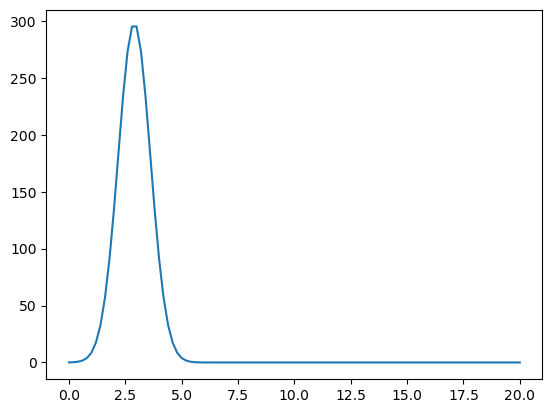

### Problema No Homogeneo

step:1 of 10 time = 1.0
H dim= 34 error = 0.0
step:2 of 10 time = 2.0
H dim= 42 error = 0.0
step:3 of 10 time = 3.0
H dim= 40 error = 0.0
step:4 of 10 time = 4.0
H dim= 71 error = 0.0
step:5 of 10 time = 5.0
H dim= 34 error = 0.0
step:6 of 10 time = 6.0
H dim= 32 error = 0.0
step:7 of 10 time = 7.0
H dim= 45 error = 0.0
step:8 of 10 time = 8.0
H dim= 51 error = 0.0
step:9 of 10 time = 9.0
H dim= 34 error = 0.0
step:10 of 10 time = 10.0
H dim= 32 error = 0.0


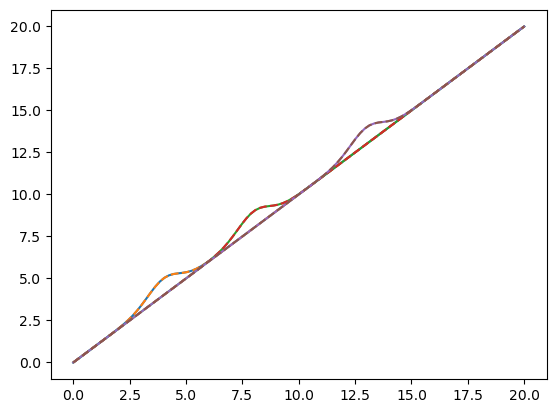

In [16]:
    

np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
start_code = time.time()
dt = 1
nx = ny = 100  #nx ny
solver  = 'exp'  # time integration method
tpe ="auto"
# Parámetros de simulación
T = 10         # Tiempo final
num_steps = int(round(T/dt,0))# Número de pasos de tiempo
real_dt= T/num_steps
#f=Expression('x[0]*(6*t - pow(x[0], 2) - 4*pow(x[0], 2)*t*t)*exp(-t*pow(x[0], 2))',t=0,degree=2)
f=Expression('1',t=0,degree=2) 
#f=Expression('4',t=0,degree=2) 
#q=Expression('-1',t=0,degree=2) #neumman BC
u_a = Expression('1/(sqrt(1+0.0004*t))*exp(-pow((x[0]-3-t),2)/(1+0.0004*t))+x[0]',t=0,degree=2)

u_0 = Expression('exp(-pow((x[0]-3),2))+x[0]',degree=2)
#u_0 = Expression('0.01*x[0]+1',degree=2)
#bc_1= 0 #left
#bc_2= Expression('0',t=0,degree=2)
BDF_coef = {"BDF1":[1,-1,0,0],"BDF2":[3./2,-2,1./2,0.0],"BDF3":[11/6,-3,3/2,-1/3],"BDF_OP":[0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3]}

# Creación de la malla y definición del espacio de funciones

start = 0
x_end = 20
mesh = IntervalMesh(nx, start, x_end)
contorno = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
left().mark(contorno, 1)
right().mark(contorno, 2)



t= 0
if solver == "exp":
    assemble_ti=time.time()
    V,u_t,v_t,A,C_1,Q_a,u_n,bcs = exp_form_no(mesh)
    assemble_t =time.time()- assemble_ti
elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
    V,L,R,bcs,u_n,u_nn,u_nnn = BDF_form(mesh,BDF_coef[solver])
else: 
    print("esquema de integración temporal erroneo")
    exit()
u_=Function(V)

L2=[]
table =[]
for n in range(num_steps):
    f.t=t
    #q.t=t
    t += real_dt
    u_a.t=t
    print(f'step:{n+1} of {num_steps} time = {t}')
    if solver == "exp":
        if tpe == 'auto': 
            Q=Q_t_no(Q_a,C_1,u_t,v_t,f,bcs)

            if n ==0:
                u_i=np.dot(A,u_n.vector().get_local())+Q
                u =exp_solver_no(A,u_i,n,table,True,0)
            else:
                u_i=np.dot(A,np.array(u)[0])+Q
                u =exp_solver_no(A,u_i,n,table,True,0,u)
        else: 
            m_u = int(mode_KSP)
            Q=Q_t_no(Q_a,C_1,u_t,v_t,f,bcs)
            if n ==0:
                u_i=np.dot(A,u_n.vector().get_local())+Q
                u =exp_solver_no(A,u_i,n,table,False,m_u)
            else:
                u_i=np.dot(A,np.array(u)[0])+Q
                u =exp_solver_no(A,u_i,n,table,False,m_u,u)
        u_.vector()[:]=np.array(u)[0]
    elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
        solve(L == R, u_)
        u_nnn.assign(u_nn)
        u_nn.assign(u_n)
        u_n.assign(u_)

    x_cor=np.linspace(start,x_end,nx)

    # u_.rename("u_"+solver, "u_"+solver);vtkfile_uh.write(u_, t)
    # u_a_=project(u_a,V)
    # u_a_.rename("u", "u");vtkfile_u.write(u_a_, t) 

    u_p=[]
    u_an=[]
    for i in x_cor:
        u_p.append(u_(i))
        u_an.append(u_a(i))
    if near(t,real_dt,real_dt/2) or near(t,5,real_dt/2) or near(t,10,real_dt/2):
        plt.plot(x_cor,u_p)
        plt.plot(x_cor,u_an,'--')
    L2_norm=np.sum((np.array(u_an)-np.array(u_p))**2)**0.5 #assemble((u_ - u_an)**2 * dx)**0.5
    L2.append([L2_norm,t])
# plt.grid(True)
# plt.xlim = [0,100]
# plt.ylim = [0,6]
plt.show()    

end_code = time.time()
exec_t=end_code-start_code



In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 



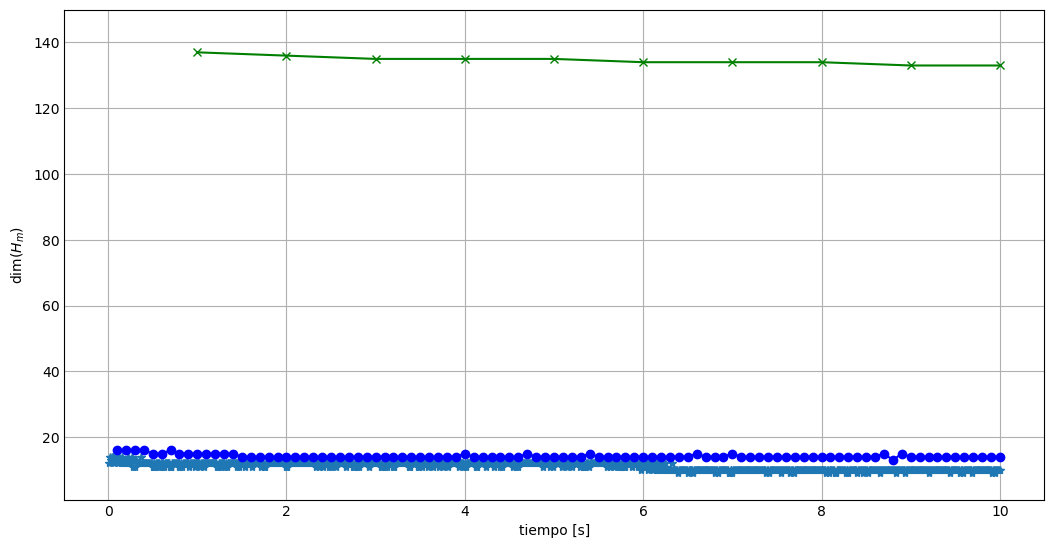

In [71]:
dt = pd.read_csv('no_homogeneo/results_dt_0.01/error_scheme_exp.csv')
dt1 = pd.read_csv('no_homogeneo/results_dt_0.1/error_scheme_exp.csv')
dt2 = pd.read_csv('no_homogeneo/results_dt_1.0/error_scheme_exp.csv')

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
ax.plot(dt['time'],dt['dim H_m'],  '*')
ax.plot(dt1['time'],dt1['dim H_m'],'o',c='blue')
ax.plot(dt1['time'],dt1['dim H_m'],'-',c='blue')
ax.plot(dt2['time'],dt2['dim H_m'], 'x',c='green')
ax.plot(dt2['time'],dt2['dim H_m'], '-',c='green')
ax.set(
       ylim=(1, 150))
plt.xlabel('tiempo [s]')
plt.ylabel('dim($H_m$)')
plt.show()

In [10]:
dtxa

,Unnamed: 0,exp,tiempo,krylov_time,solver_time,dim H_m,time
0,0,0.000013,0.01,0.090669,0.000146,12.0,0.01
1,1,0.000013,0.02,0.078814,0.001822,14.0,0.02
2,2,0.000013,0.03,0.082146,0.000154,13.0,0.03
3,3,0.000013,0.04,0.108752,0.000089,14.0,0.04
4,4,0.000014,0.05,0.255580,0.000276,14.0,0.05
...,...,...,...,...,...,...,...
995,995,0.000081,9.96,0.048544,0.000355,10.0,9.96
996,996,0.000081,9.97,0.044394,0.000912,10.0,9.97
997,997,0.000081,9.98,0.050289,0.000155,10.0,9.98
998,998,0.000081,9.99,0.042101,0.000188,10.0,9.99


In [23]:
dt2['1']=dt1['1']
dt2['2']=dt1['2']
dt2

,3,4,1,2
0,2,2,0,0
1,3,3,1,1


In [39]:
l=[[1,0],[1,1]]

In [40]:
np.array(l)[:,0]

array([1, 1])

In [37]:
dt1

,1,2,sa
0,0,0,0
1,1,1,1
